## Load Data

### Do imports

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    np, xr, plt, sns, os, 
    datetime, gridspec, 
    Iterable, cmaps, glob, copy,
    dask,pd
    )

from functions import (
    add_weights,
    to_png, stats, fix_cesm_time
    )

from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load pre-processed timeseries

In [2]:
tseries_savedir = '/glade/u/home/jonahshaw/w/LENS/CESM1-LE/ArcticTimeSeries/'

cesm1_pic_ds = xr.open_dataset('%s/CESM1_PIControl_ArcticTimeSeries.nc' % tseries_savedir)
cesm1_forcedresponse_ds = xr.open_dataset('%s/CESM1_ForcedResponse_ArcticTimeSeries.nc' % tseries_savedir)
cesm1_ensresponse_ds = xr.open_dataset('%s/CESM1_RCP8.5Members_ArcticTimeSeries.nc' % tseries_savedir)

Get the variables.

In [3]:
ens_vars = list(cesm1_pic_ds.data_vars)

In [34]:
# Define a function for standardizing data to be used before calculating an autocorrelation
def standardize(data,testing=False):
    ''' Standardize the data. '''
    
    # if data.std()==0: # edge case that the standard deviation is zero
    if np.isclose(data.std(),0,atol=1e-5): # edge case that the standard deviation is zero
        data_std = (data - data.mean())
        np.testing.assert_allclose(data_std.mean(),0,atol=1e-5)
        return data_std
    else:
        data_std = (data - data.mean()) / data.std()
    
    if testing:
        print(data)
        print(data_std)
    
    try:
        np.testing.assert_allclose(data_std.mean(),0,atol=1e-5)
        np.testing.assert_allclose(data_std.std(),1,atol=1e-5)
    except:
        print(data_std[np.isnan(data_std)])
        print(data_std.nanmean())
        print(data_std.nanstd())
        raise AssertionError()
    
    return data_std

In [35]:
def linear_polyfit(ds,dim='time.year'):
    '''
    Simple wrapped for xarray's polyfit function because I couldn't figure out how to pass arguments...
    allens_all_tseries_preproc.groupby('time.month').map(xr.Dataset.polyfit,args=('time',1)) # this should work if you use xr.DataArray?
    '''
    # ds['time'] = ds[dim] # reassign the time coordinate so that the polyfit gets units right
    ds['time'] = ds['time.year'] # reassign the time coordinate so that the polyfit gets units right, this is the old code
    
    return ds.polyfit(dim='time',deg=1)

In [36]:
def calc_tauvar(autocorrelation_data,max_lag=100,verbose=True):
    ''' 
    The Leroy paper notes that significant autocorrelation is unlikely to occur for lags greater than a few years, 
    motivating us to truncate the autocorrelation at some lag where noise starts to dominate. We need to have a method 
    to do this however. Since the "noise" is not actually centered about zero, I'll sum over the autocorrelation 
    function and pick tau as the maximum value. This might lead to tau values slightly enhanced by noise, and is 
    perhaps conservative, but I think it's probably the safest strategy.
    '''
    
    midpoint = len(autocorrelation_data)//2 # index for the midpoint of the autocorrelation data
    
    try:
        np.testing.assert_almost_equal(autocorrelation_data[midpoint],1,decimal=5) # This point should be 1 if the autocorrelation is formatted correctly and normalized
    except:
        if verbose:
            print("Midpoint of 'autocorrelation_data' is not 1. Check that data is symmetric and normalized.")
        return np.nan
    
    tau_summer = [] # array containing tau as a function of lags considered
    lags = [] # array containing the lags tested (reference)

    for lag in range(1,max_lag+1): # iterate over possible lags

        pointsabout = autocorrelation_data[midpoint-lag:midpoint+1+lag] # get all points within the lag for the autocorrelation function
        test_tau = np.sum(pointsabout) 

        tau_summer.append(test_tau)
        lags.append(lag)
    
    max_tau = np.max(tau_summer)
    
    if verbose:
        print('Maximum Tau of %.2f found at lag %d.' % (max_tau,lags[np.argmax(tau_summer)]))
    
    return max_tau

In [37]:
def calc_autocorr(data):
        
    # standardize the data
    data_std = standardize(data) # Standardize the timeseries so the autocorrelation has correct units
    autocorr = np.correlate(data_std,data_std,mode='same') / len(data_std)
    
    return autocorr

def calc_lag1_autocorr(data):
    
    autocorr = calc_autocorr(data)
    
    _lag1_index = len(autocorr) // 2 + 1 # The lag-1 autocorrelation is just off the center of the autocorrelation function, get this index
    _lag1_autocorr = autocorr[_lag1_index] # Get the lag-1 autocorrelation
    
    return xr.DataArray(_lag1_autocorr) # convert back to a dataarray object so xarray can try to concatenate

def calc_tauvar_wrapper(data):
    
    return xr.DataArray(calc_tauvar(calc_autocorr(data),verbose=False))

In [38]:
def calc_tauvar_by_dur(data,ann_tsel,durations):
    '''Wrapper for calculating correlation times for different durations'''
    
    if type(data) == xr.core.dataset.Dataset:
        return __calc_tauvar_by_dur_DATASET(data,ann_tsel,durations)
    elif type(data) == xr.core.dataarray.DataArray:
        return __calc_tauvar_by_dur_DATAARRAY(data,ann_tsel,durations)
    else:
        print('First argument must be a xr.core.dataset.Dataset or xr.core.dataarray.DataArray object.')

        
def __calc_tauvar_by_dur_DATASET(data,ann_tsel,durations):
    
    annavg_tauvar_dict  = {}
    monthly_tauvar_dict = {}
    
    for _var in data.data_vars:
        print(_var)
        ens_tseries = data[_var] # select your variable

        # turn into annual tseries, need to sub-select by year because we don't have a full year at the beginning or end of the timeseries
        ens_tseries_ann     = ens_tseries.sel(time=ann_tsel).groupby('time.year').mean('time')
        ens_tseries_monthly = ens_tseries.sel(time=ann_tsel)

        tauvar_dict = {}
        tauvar_monthly_dict = {}
        for _dur in durations: # iterate over possible detection durations 
            tseries_dur_subset         = ens_tseries_ann.isel(year=slice(None,_dur)) # subset the annual resolution data in time
            tseries_dur_monthly_subset = ens_tseries_monthly.isel(time=slice(None,12*_dur)) # subset the monthly resolution data in time

            # Handle higher dimensional timeseries fluently (i.e. the AIRS sOLR data is indexed by both time and wavenumber (wnum))
            non_time_dims = list(tseries_dur_subset.dims)
            non_time_dims.remove('year') # drop the time dim
            if len(non_time_dims)==0:
                annual_tau_var  = calc_tauvar_wrapper(tseries_dur_subset)
                monthly_tau_var = tseries_dur_monthly_subset.groupby('time.month').map(calc_tauvar_wrapper)
            else:
                annual_data_stacked = tseries_dur_subset.stack(temp_index=non_time_dims)
                annual_tau_var = annual_data_stacked.groupby('temp_index',restore_coord_dims=True).map(calc_tauvar_wrapper).unstack()

                # this bullshit roundabout method is the bastard child of this shittastic stackoverflow page: 
                # https://stackoverflow.com/questions/63082479/how-to-replace-the-current-dimension-of-an-xarray-object-with-two-new-ones
                # We want to reshape the wavenumber X time structure into a wavenumber X month X year structure, but xarray doesn't want to go easily

                # Add new year and month coordinates
                tseries_dur_monthly_subset_newcoords = tseries_dur_monthly_subset.assign_coords(
                    {
                        'year' :tseries_dur_monthly_subset['time.year'],
                        'month':tseries_dur_monthly_subset['time.month'],
                    }
                )

                # Destroy all hierarchy in the data by sending to pandas and hard-reseting the indices.
                # Finally, set the indices to our chosen year X month X wavenumber and return to xarray
                tseries_dur_monthly_subset_reorg = tseries_dur_monthly_subset_newcoords.to_dataframe().reset_index().set_index(['year','month','wnum']).to_xarray() 

                non_year_dims = list(tseries_dur_monthly_subset_reorg.dims)
                non_year_dims.remove('year') # drop the time dim

                monthly_data_stacked = tseries_dur_monthly_subset_reorg.stack(temp_index=non_year_dims)
                monthly_data_stacked = monthly_data_stacked[_var] #.to_array()
                monthly_tau_var = monthly_data_stacked.groupby('temp_index',restore_coord_dims=True).map(calc_tauvar_wrapper).unstack()
            
            # Add a 'duration' coordinate
            annual_tau_var  = annual_tau_var.assign_coords({'duration':_dur}).expand_dims('duration',axis=-1)
            monthly_tau_var = monthly_tau_var.assign_coords({'duration':_dur}).expand_dims('duration',axis=-1)

            annual_tau_var.name  = _var
            monthly_tau_var.name = _var
            
            tauvar_dict[_dur] = annual_tau_var # save slopes in an inner dictionary
            tauvar_monthly_dict[_dur] = monthly_tau_var
            
        # combine the data along the new 'duration' dimension
        _temp_tauvar_da = xr.merge(list(tauvar_dict.values()))

        _temp_tauvar_monthly_da = xr.merge(list(tauvar_monthly_dict.values()))
        
        del tauvar_dict,tauvar_monthly_dict
        
        annavg_tauvar_dict[_var] = _temp_tauvar_da
        monthly_tauvar_dict[_var] = _temp_tauvar_monthly_da

    data_tauvar_dur_ds = xr.merge(annavg_tauvar_dict.values())
    data_tauvar_monthly_dur_ds = xr.merge(monthly_tauvar_dict.values())

    del annavg_tauvar_dict,monthly_tauvar_dict
    return data_tauvar_dur_ds,data_tauvar_monthly_dur_ds


def __calc_tauvar_by_dur_DATAARRAY(data,ann_tsel,durations):
        
    ens_tseries = data
    _var = data.name

    # turn into annual tseries, need to sub-select by year because we don't have a full year at the beginning or end of the timeseries
    ens_tseries_ann = ens_tseries.sel(time=ann_tsel).groupby('time.year').mean('time')
    ens_tseries_monthly = ens_tseries.sel(time=ann_tsel)

    tauvar_dict = {}
    tauvar_monthly_dict = {}
    for _dur in durations: # iterate over possible detection durations 
        tseries_dur_subset         = ens_tseries_ann.isel(year=slice(None,_dur)) # subset the annual resolution data in time
        tseries_dur_monthly_subset = ens_tseries_monthly.isel(time=slice(None,12*_dur)) # subset the monthly resolution data in time

        # Handle higher dimensional timeseries fluently (i.e. the AIRS sOLR data is indexed by both time and wavenumber (wnum))
        non_time_dims = list(tseries_dur_subset.dims)
        non_time_dims.remove('year') # drop the time dim
        if len(non_time_dims)==0:
            annual_tau_var  = calc_tauvar_wrapper(tseries_dur_subset)
            monthly_tau_var = tseries_dur_monthly_subset.groupby('time.month').map(calc_tauvar_wrapper)
        else:
            annual_data_stacked = tseries_dur_subset.stack(temp_index=non_time_dims)
            annual_tau_var = annual_data_stacked.groupby('temp_index',restore_coord_dims=True).map(calc_tauvar_wrapper).unstack()

            # this bullshit roundabout method is the bastard child of this shittastic stackoverflow page: 
            # https://stackoverflow.com/questions/63082479/how-to-replace-the-current-dimension-of-an-xarray-object-with-two-new-ones
            # We want to reshape the wavenumber X time structure into a wavenumber X month X year structure, but xarray doesn't want to go easily

            # Add new year and month coordinates
            tseries_dur_monthly_subset_newcoords = tseries_dur_monthly_subset.assign_coords(
                {
                    'year' :tseries_dur_monthly_subset['time.year'],
                    'month':tseries_dur_monthly_subset['time.month'],
                }
            )

            # Destroy all hierarchy in the data by sending to pandas and hard-reseting the indices.
            # Finally, set the indices to our chosen year X month X wavenumber and return to xarray
            tseries_dur_monthly_subset_reorg = tseries_dur_monthly_subset_newcoords.to_dataframe().reset_index().set_index(['year','month','wnum']).to_xarray() 

            non_year_dims = list(tseries_dur_monthly_subset_reorg.dims)
            non_year_dims.remove('year') # drop the time dim

            monthly_data_stacked = tseries_dur_monthly_subset_reorg.stack(temp_index=non_year_dims)
            monthly_tau_var = monthly_data_stacked.groupby('temp_index',restore_coord_dims=True).map(calc_tauvar_wrapper).unstack()

        # Add a 'duration' coordinate
        annual_tau_var  = annual_tau_var.assign_coords({'duration':_dur}).expand_dims('duration',axis=-1)
        monthly_tau_var = monthly_tau_var.assign_coords({'duration':_dur}).expand_dims('duration',axis=-1)

        annual_tau_var.name  = _var
        monthly_tau_var.name = _var

        tauvar_dict[_dur] = annual_tau_var # save slopes in an inner dictionary
        tauvar_monthly_dict[_dur] = monthly_tau_var

    # combine the data along the new 'duration' dimension
    _temp_tauvar_da = xr.merge(list(tauvar_dict.values()))

    _temp_tauvar_monthly_da = xr.merge(list(tauvar_monthly_dict.values()))

    del tauvar_dict,tauvar_monthly_dict
    return _temp_tauvar_da,_temp_tauvar_monthly_da

In [39]:
def calc_lag1_by_dur(data,ann_tsel,durations):
    '''Wrapper for calculating correlation times for different durations'''
    
    if type(data) == xr.core.dataset.Dataset:
        return __calc_lag1_by_dur_DATASET(data,ann_tsel,durations)
    elif type(data) == xr.core.dataarray.DataArray:
        return __calc_lag1_by_dur_DATAARRAY(data,ann_tsel,durations)
    else:
        print('First argument must be a xr.core.dataset.Dataset or xr.core.dataarray.DataArray object.')

        
def __calc_lag1_by_dur_DATASET(data,ann_tsel,durations):
    
    annavg_lag1_dict  = {}
    monthly_lag1_dict = {}
    
    for _var in data.data_vars:
        print(_var)
        ens_tseries = data[_var] # select your variable

        # turn into annual tseries, need to sub-select by year because we don't have a full year at the beginning or end of the timeseries
        ens_tseries_ann     = ens_tseries.sel(time=ann_tsel).groupby('time.year').mean('time')
        ens_tseries_monthly = ens_tseries.sel(time=ann_tsel)

        lag1_dict = {}
        lag1_monthly_dict = {}
        for _dur in durations: # iterate over possible detection durations 
            tseries_dur_subset         = ens_tseries_ann.isel(year=slice(None,_dur)) # subset the annual resolution data in time
            tseries_dur_monthly_subset = ens_tseries_monthly.isel(time=slice(None,12*_dur)) # subset the monthly resolution data in time

            # Handle higher dimensional timeseries fluently (i.e. the AIRS sOLR data is indexed by both time and wavenumber (wnum))
            non_time_dims = list(tseries_dur_subset.dims)
            non_time_dims.remove('year') # drop the time dim
            if len(non_time_dims)==0:
                annual_lag1  = calc_lag1_autocorr(tseries_dur_subset)
                monthly_lag1 = tseries_dur_monthly_subset.groupby('time.month').map(calc_lag1_autocorr)
            else:
                annual_data_stacked = tseries_dur_subset.stack(temp_index=non_time_dims)
                annual_lag1 = annual_data_stacked.groupby('temp_index',restore_coord_dims=True).map(calc_lag1_autocorr).unstack()

                # this bullshit roundabout method is the bastard child of this shittastic stackoverflow page: 
                # https://stackoverflow.com/questions/63082479/how-to-replace-the-current-dimension-of-an-xarray-object-with-two-new-ones
                # We want to reshape the wavenumber X time structure into a wavenumber X month X year structure, but xarray doesn't want to go easily

                # Add new year and month coordinates
                tseries_dur_monthly_subset_newcoords = tseries_dur_monthly_subset.assign_coords(
                    {
                        'year' :tseries_dur_monthly_subset['time.year'],
                        'month':tseries_dur_monthly_subset['time.month'],
                    }
                )

                # Destroy all hierarchy in the data by sending to pandas and hard-reseting the indices.
                # Finally, set the indices to our chosen year X month X wavenumber and return to xarray
                tseries_dur_monthly_subset_reorg = tseries_dur_monthly_subset_newcoords.to_dataframe().reset_index().set_index(['year','month','wnum']).to_xarray() 

                non_year_dims = list(tseries_dur_monthly_subset_reorg.dims)
                non_year_dims.remove('year') # drop the time dim

                monthly_data_stacked = tseries_dur_monthly_subset_reorg.stack(temp_index=non_year_dims)
                monthly_data_stacked = monthly_data_stacked[_var] #.to_array()
                monthly_lag1 = monthly_data_stacked.groupby('temp_index',restore_coord_dims=True).map(calc_lag1_wrapper).unstack()
            
            # Add a 'duration' coordinate
            annual_lag1  = annual_lag1.assign_coords({'duration':_dur}).expand_dims('duration',axis=-1)
            monthly_lag1 = monthly_lag1.assign_coords({'duration':_dur}).expand_dims('duration',axis=-1)

            annual_lag1.name  = _var
            monthly_lag1.name = _var
            
            lag1_dict[_dur] = annual_lag1 # save slopes in an inner dictionary
            lag1_monthly_dict[_dur] = monthly_lag1
            
        # combine the data along the new 'duration' dimension
        _temp_lag1_da = xr.merge(list(lag1_dict.values()))

        _temp_lag1_monthly_da = xr.merge(list(lag1_monthly_dict.values()))
        
        del lag1_dict,lag1_monthly_dict
        
        annavg_lag1_dict[_var] = _temp_lag1_da
        monthly_lag1_dict[_var] = _temp_lag1_monthly_da

    data_lag1_dur_ds = xr.merge(annavg_lag1_dict.values())
    data_lag1_monthly_dur_ds = xr.merge(monthly_lag1_dict.values())

    del annavg_lag1_dict,monthly_lag1_dict
    return data_lag1_dur_ds,data_lag1_monthly_dur_ds


def __calc_lag1_by_dur_DATAARRAY(data,ann_tsel,durations):
        
    ens_tseries = data
    _var = data.name

    # turn into annual tseries, need to sub-select by year because we don't have a full year at the beginning or end of the timeseries
    ens_tseries_ann = ens_tseries.sel(time=ann_tsel).groupby('time.year').mean('time')
    ens_tseries_monthly = ens_tseries.sel(time=ann_tsel)

    lag1_dict = {}
    lag1_monthly_dict = {}
    for _dur in durations: # iterate over possible detection durations 
        tseries_dur_subset         = ens_tseries_ann.isel(year=slice(None,_dur)) # subset the annual resolution data in time
        tseries_dur_monthly_subset = ens_tseries_monthly.isel(time=slice(None,12*_dur)) # subset the monthly resolution data in time

        # Handle higher dimensional timeseries fluently (i.e. the AIRS sOLR data is indexed by both time and wavenumber (wnum))
        non_time_dims = list(tseries_dur_subset.dims)
        non_time_dims.remove('year') # drop the time dim
        if len(non_time_dims)==0:
            annual_lag1  = calc_lag1_autocorr(tseries_dur_subset)
            monthly_lag1 = tseries_dur_monthly_subset.groupby('time.month').map(calc_lag1_autocorr)
        else:
            annual_data_stacked = tseries_dur_subset.stack(temp_index=non_time_dims)
            annual_lag1 = annual_data_stacked.groupby('temp_index',restore_coord_dims=True).map(calc_lag1_autocorr).unstack()

            # this bullshit roundabout method is the bastard child of this shittastic stackoverflow page: 
            # https://stackoverflow.com/questions/63082479/how-to-replace-the-current-dimension-of-an-xarray-object-with-two-new-ones
            # We want to reshape the wavenumber X time structure into a wavenumber X month X year structure, but xarray doesn't want to go easily

            # Add new year and month coordinates
            tseries_dur_monthly_subset_newcoords = tseries_dur_monthly_subset.assign_coords(
                {
                    'year' :tseries_dur_monthly_subset['time.year'],
                    'month':tseries_dur_monthly_subset['time.month'],
                }
            )

            # Destroy all hierarchy in the data by sending to pandas and hard-reseting the indices.
            # Finally, set the indices to our chosen year X month X wavenumber and return to xarray
            tseries_dur_monthly_subset_reorg = tseries_dur_monthly_subset_newcoords.to_dataframe().reset_index().set_index(['year','month','wnum']).to_xarray() 

            non_year_dims = list(tseries_dur_monthly_subset_reorg.dims)
            non_year_dims.remove('year') # drop the time dim

            monthly_data_stacked = tseries_dur_monthly_subset_reorg.stack(temp_index=non_year_dims)
            monthly_lag1 = monthly_data_stacked.groupby('temp_index',restore_coord_dims=True).map(calc_lag1_wrapper).unstack()

        # Add a 'duration' coordinate
        annual_lag1  = annual_lag1.assign_coords({'duration':_dur}).expand_dims('duration',axis=-1)
        monthly_lag1 = monthly_lag1.assign_coords({'duration':_dur}).expand_dims('duration',axis=-1)

        annual_lag1.name  = _var
        monthly_lag1.name = _var

        lag1_dict[_dur] = annual_lag1 # save slopes in an inner dictionary
        lag1_monthly_dict[_dur] = monthly_lag1

    # combine the data along the new 'duration' dimension
    _temp_lag1_da = xr.merge(list(lag1_dict.values()))

    _temp_lag1_monthly_da = xr.merge(list(lag1_monthly_dict.values()))

    del lag1_dict,lag1_monthly_dict
    return _temp_lag1_da,_temp_tauvar_monthly_da

In [40]:
def calc_stddev_by_dur(data,ann_tsel,durations):
    '''Wrapper for calculating slopes for different durations'''
    
    if type(data) == xr.core.dataset.Dataset:
        return __calc_stddev_by_dur_DATASET(data,ann_tsel,durations)
    elif type(data) == xr.core.dataarray.DataArray:
        return __calc_stddev_by_dur_DATAARRAY(data,ann_tsel,durations)
    else:
        print('First argument must be a xr.core.dataset.Dataset or xr.core.dataarray.DataArray object.')

        
def __calc_stddev_by_dur_DATASET(data,ann_tsel,durations):
    
    annavg_stddev_dict  = {}
    monthly_stddev_dict = {}
    
    for _var in data.data_vars:
        print(_var)
        ens_tseries = data[_var] # select your variable

        # turn into annual tseries, need to sub-select by year because we don't have a full year at the beginning or end of the timeseries
        ens_tseries_ann     = ens_tseries.sel(time=ann_tsel).groupby('time.year').mean('time')
        ens_tseries_monthly = ens_tseries.sel(time=ann_tsel)

        stddev_dict = {}
        stddev_monthly_dict = {}
        for _dur in durations: # iterate over possible detection durations 
            tseries_dur_subset         = ens_tseries_ann.isel(year=slice(None,_dur)) # subset the annual resolution data in time
            tseries_dur_monthly_subset = ens_tseries_monthly.isel(time=slice(None,12*_dur)) # subset the monthly resolution data in time

            annual_stddev  = tseries_dur_subset.std(dim='year')
            monthly_stddev = tseries_dur_monthly_subset.groupby('time.month').std(dim='time')

            # Add a 'duration' coordinate
            annual_stddev  = annual_stddev.assign_coords({'duration':_dur}).expand_dims('duration',axis=-1)
            monthly_stddev = monthly_stddev.assign_coords({'duration':_dur}).expand_dims('duration',axis=-1)

            annual_stddev.name  = _var
            monthly_stddev.name = _var
            
            stddev_dict[_dur] = annual_stddev # save slopes in an inner dictionary
            stddev_monthly_dict[_dur] = monthly_stddev
            
        # combine the data along the new 'duration' dimension
        _temp_stddev_da = xr.merge(list(stddev_dict.values()))

        _temp_stddev_monthly_da = xr.merge(list(stddev_monthly_dict.values()))
        
        del stddev_dict,stddev_monthly_dict
        
        annavg_stddev_dict[_var] = _temp_stddev_da
        monthly_stddev_dict[_var] = _temp_stddev_monthly_da

    data_stddev_dur_ds = xr.merge(annavg_stddev_dict.values())
    data_stddev_monthly_dur_ds = xr.merge(monthly_stddev_dict.values())

    del annavg_stddev_dict,monthly_stddev_dict
    return data_stddev_dur_ds,data_stddev_monthly_dur_ds

    # return data.map(__calc_stddev_by_dur_DATAARRAY,ann_tsel=ann_tsel,durations=durations)


def __calc_stddev_by_dur_DATAARRAY(data,ann_tsel,durations):
        
    ens_tseries = data
    _var = data.name

    # turn into annual tseries, need to sub-select by year because we don't have a full year at the beginning or end of the timeseries
    ens_tseries_ann = ens_tseries.sel(time=ann_tsel).groupby('time.year').mean('time')
    ens_tseries_monthly = ens_tseries.sel(time=ann_tsel)

    stddev_dict = {}
    stddev_monthly_dict = {}
    for _dur in durations: # iterate over possible detection durations 
        tseries_dur_subset         = ens_tseries_ann.isel(year=slice(None,_dur)) # subset the annual resolution data in time
        tseries_dur_monthly_subset = ens_tseries_monthly.isel(time=slice(None,12*_dur)) # subset the monthly resolution data in time

        annual_stddev  = tseries_dur_subset.std(dim='year')
        monthly_stddev = tseries_dur_monthly_subset.groupby('time.month').std(dim='time')

        # Add a 'duration' coordinate
        annual_stddev  = annual_stddev.assign_coords({'duration':_dur}).expand_dims('duration',axis=-1)
        monthly_stddev = monthly_stddev.assign_coords({'duration':_dur}).expand_dims('duration',axis=-1)

        annual_stddev.name  = _var
        monthly_stddev.name = _var

        stddev_dict[_dur] = annual_stddev # save slopes in an inner dictionary
        stddev_monthly_dict[_dur] = monthly_stddev

    # combine the data along the new 'duration' dimension
    _temp_stddev_da = xr.merge(list(stddev_dict.values()))

    _temp_stddev_monthly_da = xr.merge(list(stddev_monthly_dict.values()))

    del stddev_dict,stddev_monthly_dict
    return _temp_stddev_da,_temp_stddev_monthly_da

### Do calculations

### Calculate standard deviation by dur

I need to do this annually and monthly.

In [45]:
min_dur = 5
max_dur = 1800

step_dur = 5

pic_durations = np.arange(min_dur,max_dur+1,step_dur)

In [46]:
pic_tsel = slice('0400-01-01','2200-12-31')

stddevs_ann,stddevs_monthly = calc_stddev_by_dur(cesm1_pic_ds,ann_tsel=pic_tsel,durations=pic_durations)

FLUT
FLUTC
TS
ICEFRAC
TMQ
FSNTOA
FSNTOAC
FSNS
FSNSC


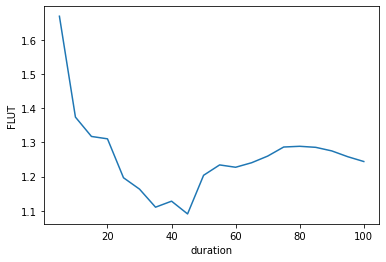

In [49]:
stddevs_ann['FLUT'].sel(duration=slice(2,100)).plot()

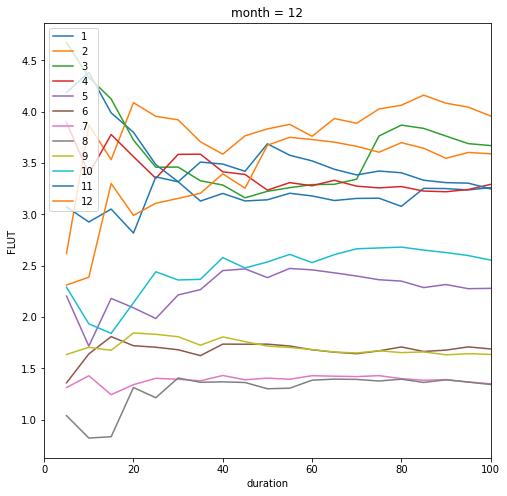

In [59]:
plt.subplots(1,1,figsize=(8,8))

for i,_monthly_data in enumerate(stddevs_monthly['FLUT']):
    # print(_monthly_data)
    
    _monthly_data.plot(label=i+1)
    
plt.xlim(0,100)
plt.legend()

The Shaw metric performs the worst for ICEFRAC and FLUTC monthly. Let's look at the autocorrelation and standard deviation of these variables monthly.

The first five months of the year are the worst. This doesn't make any sense to me.

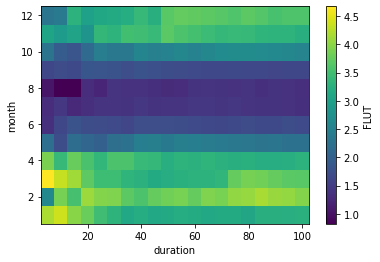

In [50]:
stddevs_monthly['FLUT'].sel(duration=slice(2,100)).plot()

Annually.

In [60]:
min_duration = 3
max_duration = 600

durations = np.arange(min_duration,max_duration+1)

In [61]:
cesm1_tauvar_ann_A,cesm1_tauvar_monthly_A = calc_tauvar_by_dur(cesm1_pic_ds,slice('0400-01-01','0999-12-31'),durations=durations)

cesm1_tauvar_ann_B,cesm1_tauvar_monthly_B = calc_tauvar_by_dur(cesm1_pic_ds,slice('1000-01-01','1599-12-31'),durations=durations)

cesm1_tauvar_ann_C,cesm1_tauvar_monthly_C = calc_tauvar_by_dur(cesm1_pic_ds,slice('1601-01-01','2199-12-31'),durations=durations)

FLUT
FLUTC
TS
ICEFRAC
TMQ
FSNTOA
FSNTOAC
FSNS
FSNSC
FLUT
FLUTC
TS
ICEFRAC
TMQ
FSNTOA
FSNTOAC
FSNS
FSNSC
FLUT
FLUTC
TS
ICEFRAC
TMQ
FSNTOA
FSNTOAC
FSNS
FSNSC


In [62]:
cesm1_lag1_ann_A,cesm1_lag1_monthly_A = calc_lag1_by_dur(cesm1_pic_ds,slice('0400-01-01','0999-12-31'),durations=durations)

cesm1_lag1_ann_B,cesm1_lag1_monthly_B = calc_lag1_by_dur(cesm1_pic_ds,slice('1000-01-01','1599-12-31'),durations=durations)

cesm1_lag1_ann_C,cesm1_lag1_monthly_C = calc_lag1_by_dur(cesm1_pic_ds,slice('1601-01-01','2199-12-31'),durations=durations)

FLUT
FLUTC
TS
ICEFRAC
TMQ
FSNTOA
FSNTOAC
FSNS
FSNSC
FLUT
FLUTC
TS
ICEFRAC
TMQ
FSNTOA
FSNTOAC
FSNS
FSNSC
FLUT
FLUTC
TS
ICEFRAC
TMQ
FSNTOA
FSNTOAC
FSNS
FSNSC


FLUT FLUT
FLUTC FLUTC
TS TS
ICEFRAC ICEFRAC
TMQ TMQ
FSNTOA FSNTOA
FSNTOAC FSNTOAC
FSNS FSNS
FSNSC FSNSC


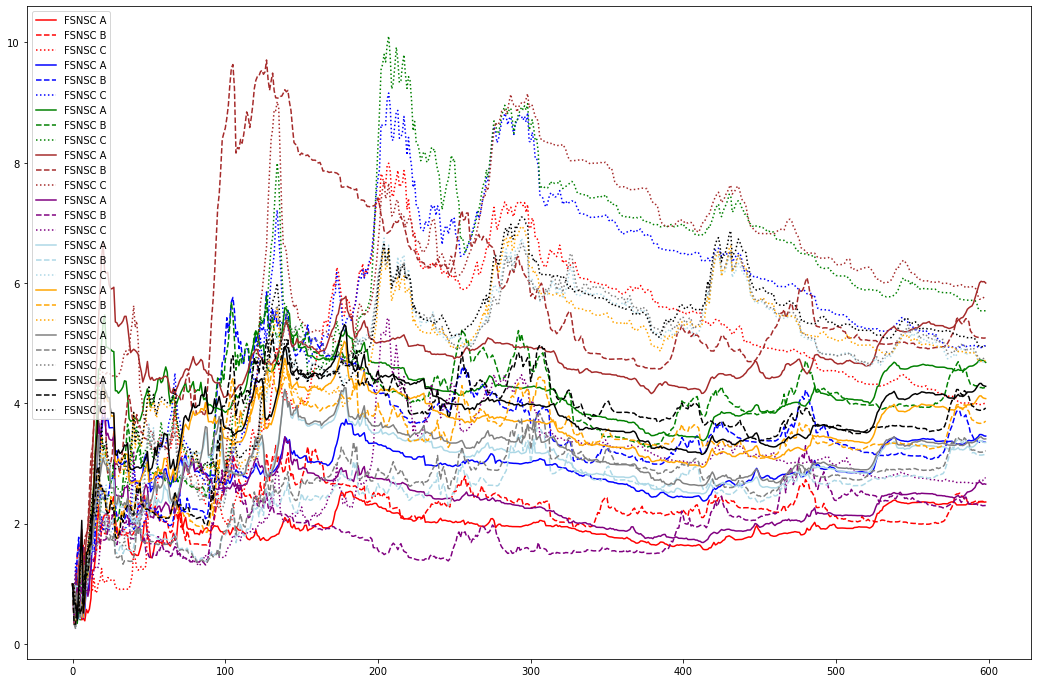

In [43]:
tauvar_fig,tauvar_ax = plt.subplots(1,1,figsize=(18,12))

colors = ['red','blue','green','brown','purple','lightblue','orange','grey','black']

for _varA,_varB,_varC,_color in zip(cesm1_tauvar_ann_A,cesm1_tauvar_ann_B,cesm1_tauvar_ann_C,colors):
    print(_varA,_varB)
    tauvar_ax.plot(cesm1_tauvar_ann_A[_varA],label=_var+' A',c=_color)
    tauvar_ax.plot(cesm1_tauvar_ann_B[_varB],label=_var+' B',linestyle='dashed',c=_color)
    tauvar_ax.plot(cesm1_tauvar_ann_C[_varC],label=_var+' C',linestyle='dotted',c=_color)
    # break
    
plt.legend()

This plot is telling me that in the best case scenario, it take ~100 years for us to know the "true" autocorrelation time well.

FLUT FLUT
FLUTC FLUTC
TS TS
ICEFRAC ICEFRAC
TMQ TMQ
FSNTOA FSNTOA
FSNTOAC FSNTOAC
FSNS FSNS
FSNSC FSNSC


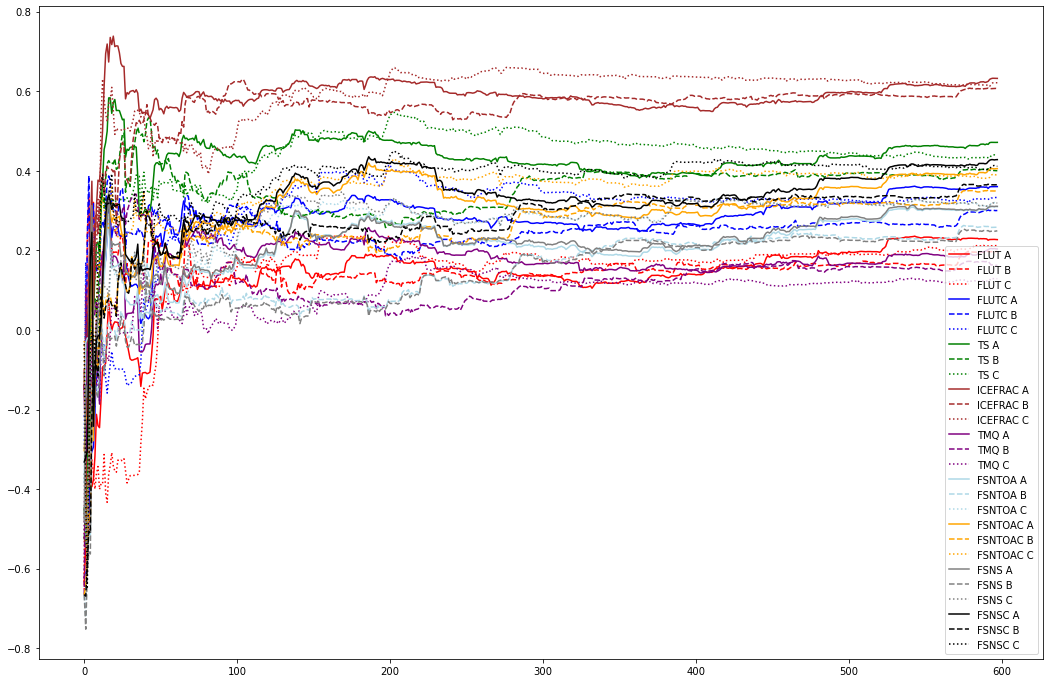

In [59]:
lag1_fig,lag1_ax = plt.subplots(1,1,figsize=(18,12))

colors = ['red','blue','green','brown','purple','lightblue','orange','grey','black']

for _varA,_varB,_varC,_color in zip(cesm1_lag1_ann_A,cesm1_lag1_ann_B,cesm1_lag1_ann_C,colors):
    print(_varA,_varB)
    lag1_ax.plot(cesm1_lag1_ann_A[_varA],label=_varA+' A',c=_color)
    lag1_ax.plot(cesm1_lag1_ann_B[_varB],label=_varB+' B',linestyle='dashed',c=_color)
    lag1_ax.plot(cesm1_lag1_ann_C[_varC],label=_varC+' C',linestyle='dotted',c=_color)
    # break
    
plt.legend()

This plot is telling me that in the best case scenario, it takes a >50 years for us to know the "true" lag-1 autocorrelation well. And even then, there is quite a bit of uncertainty.

In [20]:
_tauvar_dict = {}
_tauvar_monthly_list   = []


for _var in ens_vars:
    print(_var)
    _tauvar_dict[_var] = calc_tauvar(_autocorr_dict[_var],verbose=False)
    
    _monthly_tauvars = cesm1_pic_ds[_var].groupby('time.month').map(calc_tauvar_wrapper) # this calculates the autocorr on its way to tauvar, so its fine
    _monthly_tauvars.name = _var # assign the correct name for future concatenation
    
    _tauvar_monthly_list.append(_monthly_tauvars)
    
tauvar_monthly_ds = xr.merge(_tauvar_monthly_list) # FSNTOA December tauvar is None, good job code!

FLUT
FLUTC
TS
ICEFRAC
TMQ
FSNTOA
Midpoint of 'autocorrelation_data' is not 1. Check that data is symmetric and normalized.
FSNTOAC
Midpoint of 'autocorrelation_data' is not 1. Check that data is symmetric and normalized.
FSNS
Midpoint of 'autocorrelation_data' is not 1. Check that data is symmetric and normalized.
FSNSC
Midpoint of 'autocorrelation_data' is not 1. Check that data is symmetric and normalized.
